# Classificação: aprendizado semi-supervisionado

Uma indústria de laticínios precisa assegurar a qualidade do leite para produzir seus produtos.

Neste projeto, iremos analisar características de amostras de leite para identificar a qualidade e verificar se podem ser utilizados na produção dos produtos alimentícios.

O machine learning será utilizado para fazer a **classificação** do leite entre as qualidades **baixa, média e alta**.

O primeiro passo é fazer a leitura da base de dados, a partir do arquivo `qualidade_leite.csv`. Vamos fazer a leitura com a função [`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) da biblioteca `pandas`.

Nas colunas Sabor, Odor e Gordura, o valor 0 indica qualidade ruim da característica avaliada, enquanto o valor 1 indica qualidade boa ou bem avaliada. Já para a coluna Turbidez, o valor 0 indica ausência de turbidez e 1 a presença (quando o leite tem um aspecto transparente, diluído). A coluna cor indica a proximidade do leite com a cor branca (valor máximo de 255, com 255 sendo o mais branco), ou seja, há uma importância na grandeza.

In [1]:
import pandas as pd

df = pd.read_csv('qualidade_leite.csv')
df.head()

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor,Qualidade
0,6.6,35,1,0,1,0,254,alta
1,6.6,36,0,1,0,1,253,alta
2,8.5,70,1,1,1,1,246,NaN
3,9.5,34,1,1,0,1,255,NaN
4,6.6,37,0,0,0,0,255,média


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           1059 non-null   float64
 1   Temperatura  1059 non-null   int64  
 2   Sabor        1059 non-null   int64  
 3   Odor         1059 non-null   int64  
 4   Gordura      1059 non-null   int64  
 5   Turbidez     1059 non-null   int64  
 6   Cor          1059 non-null   int64  
 7   Qualidade    424 non-null    object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [3]:
df.describe()

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


In [4]:
# dropna=False will include NaN in the output
df['Qualidade'].value_counts(dropna=False)

NaN      635
baixa    184
média    149
alta      91
Name: Qualidade, dtype: int64

Podemos verificar que a variável alvo (coluna "Qualidade") possui dados NaN (vamos considerar como dados nulos), ou seja, **nem todas as entradas tiveram sua classificação registrada**. 

Passar dados nulos irá prejudicar o modelo (pensando no caso de um aprendizado **supervisionado**, em que mostramos ao modelo qual é a saída esperada, de modo que ele observe as variáveis explicativas procurando por padrões), então precisamos pensar em outra estratégia para o aprendizado.

## Aprendizado supervisionado

Uma estratégia inicial é removermos os dados nulos e utilizarmos o restante para treinar um modelo por meio do aprendizado supervisionado que já conhecemos.

Como modelo, utilizaremos o SVM (Support Vector Machine).

Do curso:

**Vantagens das SVMs**

- Eficientes em espaços de **muitas dimensões**;

- Efetivas em casos onde a quantidade de variáveis é maior que a quantidade de registros da base de dados;

- Eficiência de memória, porque utiliza um subconjunto de dados de treinamento na função de decisão (chamados vetores de suporte);

- Versatilidade: possui diferentes funções de Kernel para trabalhar com dados lineares e não-lineares.

**Limitações das SVMs**

- São **sensíveis à escala** dos dados, sendo necessário realizar transformações antes de utilizar os dados;

- A escolha do kernel ideal pode ser complexa por depender de cada tipo de problema;

- **Não calculam diretamente estimativas de probabilidade do modelo**. Caso necessite das estimativas, é necessário utilizar uma validação cruzada que pode ser custosa computacionalmente.


In [5]:
df_labelled = df.dropna()
df_labelled

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor,Qualidade
0,6.6,35,1,0,1,0,254,alta
1,6.6,36,0,1,0,1,253,alta
4,6.6,37,0,0,0,0,255,média
6,5.5,45,1,0,1,1,250,baixa
7,4.5,60,0,1,1,1,250,baixa
...,...,...,...,...,...,...,...,...
1047,6.8,45,1,1,1,0,245,alta
1048,9.5,34,1,1,0,1,255,baixa
1049,6.5,37,0,0,0,0,255,média
1052,6.5,40,1,0,0,0,250,média


In [6]:
df_labelled.isna().sum()

pH             0
Temperatura    0
Sabor          0
Odor           0
Gordura        0
Turbidez       0
Cor            0
Qualidade      0
dtype: int64

In [7]:
X = df_labelled.drop('Qualidade', axis=1)
y = df_labelled['Qualidade']

In [8]:
y.value_counts(dropna=False)

baixa    184
média    149
alta      91
Name: Qualidade, dtype: int64

Para o uso da SVM, vamos codificar a variável alvo (com o `LabelEncoder`) e normalizar a escala das variáveis explicativas (com o `MinMaxScaler`).

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [10]:
import numpy as np
np.unique(y)

array([0, 1, 2])

In [11]:
# if you want to check what each value represents
label_encoder.inverse_transform(np.unique(y))

array(['alta', 'baixa', 'média'], dtype=object)

Separando os dados entre treino e teste antes de fazer a transformação da escala (para evitar o data leakage).

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_train_norm.head()

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor
0,0.584615,0.017857,1.0,0.0,1.0,0.0,0.400000
1,0.538462,0.035714,0.0,0.0,0.0,0.0,0.466667
2,0.538462,0.017857,1.0,0.0,1.0,0.0,0.400000
3,0.569231,0.071429,1.0,0.0,1.0,0.0,1.000000
4,0.553846,0.196429,0.0,1.0,1.0,1.0,0.666667


In [14]:
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_test_norm.head()

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor
0,0.553846,0.017857,1.0,0.0,1.0,0.0,0.933333
1,0.538462,0.071429,1.0,1.0,1.0,1.0,1.000000
2,0.676923,1.000000,1.0,0.0,1.0,1.0,1.000000
3,0.553846,0.071429,0.0,0.0,0.0,0.0,1.000000
4,1.000000,0.000000,1.0,1.0,0.0,1.0,1.000000


Criando o modelo com o SVM (não explicou o hiperparâmetro escolhido):

In [15]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=10)
svm.fit(X_train_norm, y_train)

SVC(kernel='linear', random_state=10)

In [16]:
from sklearn.metrics import classification_report

y_pred = svm.predict(X_test_norm)
supervised_results = classification_report(y_test, y_pred)
print(supervised_results)

              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.67      0.91      0.77        46
           2       0.90      0.76      0.82        37

    accuracy                           0.75       106
   macro avg       0.77      0.69      0.70       106
weighted avg       0.77      0.75      0.73       106



## Aprendizado semi-supervisionado

Consiste em construir um modelo que utiliza tanto o modelo supervisionado que criamos, quanto o conjunto de dados não rotulados (as entradas que dropamos por terem dados nulos).

### Estratégia de *pseudo labelling*

Uma das formas de fazer isso é com a estratégia de "pseudo labelling" (pseudo-rotulagem), que consiste em utilizar o modelo que construímos para **prever** a classificação dos dados não rotulados (unlabeled), daí o nome pseudo labeling. Esses dados agora pseudo-rotulados são **incluídos em nosso conjunto de dados**, e assim utilizamos esse conjunto expandido para **treinarmos um novo modelo supervisionado**.

Selecionando os dados que tem a coluna Qualidade com valor nulo:

In [17]:
df[df['Qualidade'].isna()]

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor,Qualidade
2,8.5,70,1,1,1,1,246,NaN
3,9.5,34,1,1,0,1,255,NaN
5,6.6,37,1,1,1,1,255,NaN
8,8.1,66,1,0,1,1,255,NaN
10,6.7,45,1,1,1,0,245,NaN
...,...,...,...,...,...,...,...,...
1053,8.1,66,1,0,1,1,255,NaN
1054,6.7,45,1,1,0,0,247,NaN
1055,6.7,38,1,0,1,0,255,NaN
1056,3.0,40,1,1,1,1,255,NaN


In [18]:
X_unlabelled = df[df['Qualidade'].isna()].drop('Qualidade', axis=1)
X_unlabelled

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor
2,8.5,70,1,1,1,1,246
3,9.5,34,1,1,0,1,255
5,6.6,37,1,1,1,1,255
8,8.1,66,1,0,1,1,255
10,6.7,45,1,1,1,0,245
...,...,...,...,...,...,...,...
1053,8.1,66,1,0,1,1,255
1054,6.7,45,1,1,0,0,247
1055,6.7,38,1,0,1,0,255
1056,3.0,40,1,1,1,1,255


Lembrando que precisamos dos dados normalizados:

In [19]:
X_unlabelled_norm = pd.DataFrame(scaler.transform(X_unlabelled), columns=X_unlabelled.columns)
X_unlabelled_norm

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor
0,0.846154,0.642857,1.0,1.0,1.0,1.0,0.400000
1,1.000000,0.000000,1.0,1.0,0.0,1.0,1.000000
2,0.553846,0.053571,1.0,1.0,1.0,1.0,1.000000
3,0.784615,0.571429,1.0,0.0,1.0,1.0,1.000000
4,0.569231,0.196429,1.0,1.0,1.0,0.0,0.333333
...,...,...,...,...,...,...,...
630,0.784615,0.571429,1.0,0.0,1.0,1.0,1.000000
631,0.569231,0.196429,1.0,1.0,0.0,0.0,0.466667
632,0.569231,0.071429,1.0,0.0,1.0,0.0,1.000000
633,0.000000,0.107143,1.0,1.0,1.0,1.0,1.000000


In [20]:
y_pred = svm.predict(X_unlabelled_norm)

Vamos agora adicionar os novos dados pseudo-rotulados aos nossos dados de treinamento. Podemos fazer isso concatenando X_train_norm e X_unlabelled_norm, e y_train e y_pred.

In [21]:
# ignore_index=True will ignore the index of each df in the list and will create a new index to the concatenated result
X_train_concat = pd.concat([X_train_norm, X_unlabelled_norm], ignore_index=True)
X_train_concat

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor
0,0.584615,0.017857,1.0,0.0,1.0,0.0,0.400000
1,0.538462,0.035714,0.0,0.0,0.0,0.0,0.466667
2,0.538462,0.017857,1.0,0.0,1.0,0.0,0.400000
3,0.569231,0.071429,1.0,0.0,1.0,0.0,1.000000
4,0.553846,0.196429,0.0,1.0,1.0,1.0,0.666667
...,...,...,...,...,...,...,...
948,0.784615,0.571429,1.0,0.0,1.0,1.0,1.000000
949,0.569231,0.196429,1.0,1.0,0.0,0.0,0.466667
950,0.569231,0.071429,1.0,0.0,1.0,0.0,1.000000
951,0.000000,0.107143,1.0,1.0,1.0,1.0,1.000000


As variáveis alvo são ndarray, então precisamos transformá-las em Series para poder utilizar o concat:

In [22]:
y_train_concat = pd.concat([
    pd.Series(y_train),
    pd.Series(y_pred)
], ignore_index=True)
y_train_concat

0      2
1      2
2      2
3      0
4      0
      ..
948    1
949    1
950    0
951    1
952    2
Length: 953, dtype: int32

Criando o novo modelo

In [23]:
model_pseudo_labelling = SVC(kernel='linear', random_state=10)
model_pseudo_labelling.fit(X_train_concat, y_train_concat)

SVC(kernel='linear', random_state=10)

In [24]:
y_pred = model_pseudo_labelling.predict(X_test_norm)
pseudo_labelling_results = classification_report(y_test, y_pred)
print('Resultados com aprendizado supervisionado:')
print(supervised_results)
print('Resultados com pseudo-labelling:')
print(pseudo_labelling_results)

Resultados com aprendizado supervisionado:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.67      0.91      0.77        46
           2       0.90      0.76      0.82        37

    accuracy                           0.75       106
   macro avg       0.77      0.69      0.70       106
weighted avg       0.77      0.75      0.73       106

Resultados com pseudo-labelling:
              precision    recall  f1-score   support

           0       0.69      0.39      0.50        23
           1       0.66      0.87      0.75        46
           2       0.88      0.76      0.81        37

    accuracy                           0.73       106
   macro avg       0.74      0.67      0.69       106
weighted avg       0.74      0.73      0.72       106



Comparando as métricas, podemos ver que todas elas ficaram abaixo das obtidas com o modelo anterior, ou seja, a estratégia de pseudo labelling foi **pior** neste caso. Ela, no entanto, não é a única estratégia de aprendizado semi-supervisionado.

Do curso:

**Vantagens do Pseudo Labeling**

- Aproveitamento dos dados não rotulados com intenção de melhorar o desempenho da predição;

- Ao utilizar dados adicionais, o modelo pode capturar informações latentes que podem melhorar a generalização;

- É uma técnica relativamente **simples** de implementar que pode fornecer melhorias significativas em certos casos.

**Limitações do Pseudo Labeling**

- Os pseudo-rótulos podem conter erros, afetando negativamente o desempenho do modelo e tornando o resultado menos confiável;

- A **qualidade do modelo inicial** influencia diretamente a eficácia do pseudo-labeling.

### Estratégia *self-training*

É semelhante ao pseudo-labelling, porém ao invés de utilizar todos os dados pseudo-rotulados, utilizaremos **somente aqueles que obtiveram os melhores resultados** de confiança de acordo com o modelo (a probabilidade acima de algum threshold que informamos). Desse modo, eliminamos os resultados em que o modelo ficou incerto na classificação. 

- podemos também fazer modelos progressivos, utilizando os dados ainda não rotulados como entrada para um novo modelo e selecionando novamente as predições com maior probabilidade, que serão adicionadas ao modelo de treinamento, e assim por diante até um número X de iterações ou até que todos os dados não rotulados tenham sido adicionados.

Uma maneira de selecionar os melhores resultados é criar uma tabela de probabilidades com todos os dados pseudo-rotulados, contendo a probabilidade de a predição ser de cada classe.

O SVC possui o parâmetro booleano `probability`, para que as probabilidades da classificação sejam exibidas (default é `False`). Quando `True`, podemos usar o médodo `predict_proba` para obter as probabilidades associadas a cada predição.

In [25]:
svm = SVC(kernel='linear', probability=True, random_state=10)
svm.fit(X_train_norm, y_train)

SVC(kernel='linear', probability=True, random_state=10)

In [26]:
y_pred_proba = svm.predict_proba(X_unlabelled_norm)
y_pred = svm.predict(X_unlabelled_norm)

In [27]:
proba_results = pd.DataFrame(y_pred_proba, columns=['Prob C0', 'Prob C1', 'Prob C2'])
proba_results['Previsão'] = y_pred
proba_results.head()

,Prob C0,Prob C1,Prob C2,Previsão
0,0.147210,0.852259,0.000531,1
1,0.249874,0.715117,0.035009,1
2,0.491701,0.506534,0.001764,1
3,0.076294,0.922552,0.001155,1
4,0.693914,0.215723,0.090363,0


Para facilitar a filtragem, vamos criar uma coluna com a probabilidade máxima encontrada para cada previsão.

In [28]:
proba_results['Probabilidade máxima'] = proba_results[['Prob C0', 'Prob C1', 'Prob C2']].max(axis=1)
proba_results.head()

,Prob C0,Prob C1,Prob C2,Previsão,Probabilidade máxima
0,0.147210,0.852259,0.000531,1,0.852259
1,0.249874,0.715117,0.035009,1,0.715117
2,0.491701,0.506534,0.001764,1,0.506534
3,0.076294,0.922552,0.001155,1,0.922552
4,0.693914,0.215723,0.090363,0,0.693914


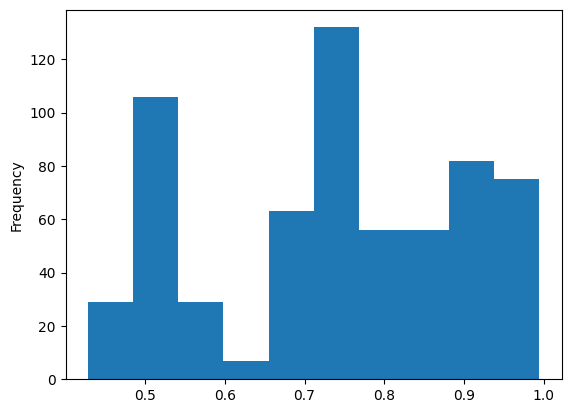

In [29]:
proba_results['Probabilidade máxima'].plot(kind='hist');

Pelo histograma, podemos verificar que existem resultados com um grau alto de incerteza (quando a probabilidade máxima está próximo de 50%). Estes não são interessantes de se inserir no treinamento.

Vamos optar por incluir no treinamento somente os resultados que obtiveram uma probabilidade máxima acima de 75%. Podemos fazer isso criando um filtro dos dados da tabela de probabilidades e utilizando-o nos datasets que contém os dados não rotulados.

In [30]:
THRESHOLD = .75
high_proba_filter = proba_results['Probabilidade máxima'] > THRESHOLD

In [31]:
X_train_highproba = pd.concat([X_train_norm, X_unlabelled_norm[high_proba_filter]])
y_train_highproba = pd.concat([
    pd.Series(y_train),
    proba_results.loc[high_proba_filter, 'Previsão'] # select rows with high_proba and then column "Previsão"
])

Criando o novo modelo:

In [32]:
model_self_training = SVC(kernel='linear', probability=True, random_state=10)
model_self_training.fit(X_train_highproba, y_train_highproba)

SVC(kernel='linear', probability=True, random_state=10)

In [33]:
y_pred = model_self_training.predict(X_test_norm)
self_training_results_1 = classification_report(y_test, y_pred)
print('Resultados com aprendizado supervisionado:')
print(supervised_results)
print('Resultados com self training (1ª iteração):')
print(self_training_results_1)

Resultados com aprendizado supervisionado:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.67      0.91      0.77        46
           2       0.90      0.76      0.82        37

    accuracy                           0.75       106
   macro avg       0.77      0.69      0.70       106
weighted avg       0.77      0.75      0.73       106

Resultados com self training (1ª iteração):
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.72      0.91      0.81        46
           2       0.92      0.89      0.90        37

    accuracy                           0.79       106
   macro avg       0.80      0.73      0.74       106
weighted avg       0.80      0.79      0.78       106



Já podemos perceber uma melhora na acurácia e nas métricas da classe 2 logo na primeira iteração do self-training. 

Podemos realizar novas rodadas de self-training com os dados que não passaram no filtro anteriormente e verificar novamente as métricas. No entanto, **o scikit-learn nos fornece uma ferramenta que já faz tudo isso de maneira automática**, o `SelfTraningClassifier`, que cria o que é chamado de "metaestimador".

In [34]:
from sklearn.semi_supervised import SelfTrainingClassifier

Para utilizar este metaestimador, iremos usar o **valor -1** para representar os **dados nulos da variável alvo**.


In [35]:
X_train_self_training = pd.concat([X_train_norm, X_unlabelled_norm], ignore_index=True)
y_train_self_training = pd.concat(
    [
        pd.Series(y_train),
        pd.Series([-1]*X_unlabelled_norm.shape[0]) # create an array of df.shape[0] elements with the value -1
    ],
    ignore_index=True
)

Inicializando o metaestimador com o modelo desejado e os dados concatenados. Utilizamos o parâmetro `max_iter` para indicar o número de iterações de self-training a serem feitas. O algoritmo para quando atingir esse número ou se não houver mais dados a serem rotulados

In [36]:
model_stc = SelfTrainingClassifier(
    base_estimator = SVC(kernel='linear', probability=True, random_state=10),
    threshold=.8, # default is 0.75
    max_iter = 15, 
    verbose=True # to display some information on each iteration
)

In [37]:
model_stc.fit(X_train_self_training, y_train_self_training)

End of iteration 1, added 244 new labels.
End of iteration 2, added 105 new labels.
End of iteration 3, added 50 new labels.
End of iteration 4, added 3 new labels.
End of iteration 5, added 14 new labels.


SelfTrainingClassifier(base_estimator=SVC(kernel='linear', probability=True,
                                          random_state=10),
                       max_iter=15, threshold=0.8, verbose=True)

In [38]:
y_pred = model_stc.predict(X_test_norm)
stc_results = classification_report(y_test, y_pred)
print('Resultados com aprendizado supervisionado:')
print(supervised_results)
print('Resultados com SelfTrainingClassifier:')
print(stc_results)

Resultados com aprendizado supervisionado:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.67      0.91      0.77        46
           2       0.90      0.76      0.82        37

    accuracy                           0.75       106
   macro avg       0.77      0.69      0.70       106
weighted avg       0.77      0.75      0.73       106

Resultados com SelfTrainingClassifier:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        23
           1       0.81      0.91      0.86        46
           2       0.92      0.89      0.90        37

    accuracy                           0.85       106
   macro avg       0.85      0.82      0.83       106
weighted avg       0.85      0.85      0.85       106



Podemos verificar que com o SelfTrainingClassifier conseguimos resultados **superiores** aos do modelo supervisionado, com todas as métricas ficando melhores (à exceção do recall da classe 1, que se manteve o mesmo).

### Estratégia *Label Propagation*

Utilização de grafos e distância entre os dados. Parece ser uma ideia de clusterizar os dados por classe (label) e adicionar aos dados não rotulados a label do cluster que eles fazem parte ou do qual estão mais próximos.

O scikit learn oferece o classificador `LabelPropagation` para essa tarefa. Do mesmo modo que no `SelfTrainingClassifier`, os dados nulos da variável alvo precisam ser substituídos por -1. Vamos usar as variáveis da Seção anterior, que já possuem esses dados

In [39]:
from sklearn.semi_supervised import LabelPropagation

label_propagation = LabelPropagation()
label_propagation.fit(X_train_self_training, y_train_self_training)

LabelPropagation()

In [40]:
y_pred = label_propagation.predict(X_test_norm)
label_propagation_results = classification_report(y_test, y_pred)
print('Resultados com SelfTrainingClassifier:')
print(stc_results)
print('Resultados com LabelPropagation:')
print(label_propagation_results)

Resultados com SelfTrainingClassifier:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        23
           1       0.81      0.91      0.86        46
           2       0.92      0.89      0.90        37

    accuracy                           0.85       106
   macro avg       0.85      0.82      0.83       106
weighted avg       0.85      0.85      0.85       106

Resultados com LabelPropagation:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.89      0.94        46
           2       0.88      0.95      0.91        37

    accuracy                           0.93       106
   macro avg       0.93      0.95      0.94       106
weighted avg       0.94      0.93      0.93       106



Resultados muito bons, com algumas métricas atingindo 100%. Bem impressionante.

Devido a esses resultados, iremos selecioná-lo para "colocar em produção".

## Armazenando o melhor modelo

Como estamos utilizando os dados normalizados, precisamos também armazenar o scaler criado no começo. Cada um será armazenado em um arquivo pickle.

In [41]:
import pickle

with open('min_max_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [42]:
with open('model_lbl_propag.pkl', 'wb') as file:
    pickle.dump(label_propagation, file)

Simulando utilização dos arquivos por outra aplicação:

In [43]:
model = pd.read_pickle('./model_lbl_propag.pkl')
scaler = pd.read_pickle('./min_max_scaler.pkl')

Utilização do modelo com um novo dado obtido:

In [44]:
new_data = pd.DataFrame({
    'pH':[6.4],
    'Temperatura':[52],
    'Sabor':[0],
    'Odor':[1],
    'Gordura':[1],
    'Turbidez':[0],
    'Cor':[253]
})

In [45]:
new_data

,pH,Temperatura,Sabor,Odor,Gordura,Turbidez,Cor
0,6.4,52,0,1,1,0,253


In [46]:
prediction = model.predict(scaler.transform(new_data))
prediction

c:\codes\ML-classificacao-Alura\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LabelPropagation was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

(o warning é porque o transform do scaler retorna os dados em um array, e não um dataframe. Para não ver esse warning, crie um dataframe com o retorno do scaler e passe o nome das colunas via parâmetro `columns`).

Se tivéssemos também salvo o label encoder, poderíamos dar a string do resultado da classificação:

In [47]:
label_encoder.inverse_transform(prediction)[0]

'alta'